## All imports

In [54]:
from attention import AttentionLayer
import pandas as pandas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
import re

In [5]:
from bs4 import BeautifulSoup

In [6]:
import warnings

In [7]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

## Preprocessing of the data

In [8]:
data=pd.read_csv(r"D:\ML\Datasets\Amazon food review 5M\Reviews.csv", nrows=100000)
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."


In [9]:

data=data.drop_duplicates(subset=['Text'])  #dropping duplicates
data=data.dropna(axis=0)   #dropping na

In [10]:
data["Text"][:5]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

## Removing items-
#### Convert everything to lowercase
#### Remove HTML tags
#### Contraction mapping
#### Remove (‘s)
#### Remove any text inside the parenthesis ( )
#### Eliminate punctuations and special characters
#### Remove stopwords
#### Remove short words

In [11]:
from contraction import contraction_mapping

In [12]:
stop_words= set(stopwords.words('english'))   #grammar words
def text_cleaner(text):
    finalString = text.lower()
    finalString = BeautifulSoup(finalString, "lxml").text
    finalString = re.sub(r'\([^)]*\)', '', finalString)
    finalString = re.sub('"','', finalString)
    finalString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in          finalString.split(" ")]) 
    finalString = re.sub(r"'s\b", "", finalString)
    finalString = re.sub("[^a-zA-Z]", " ", finalString)
    tokens = [w for w in finalString.split() if not w in stop_words]
    long_words = []
    for i in tokens:
        if(len(tokens)>=3):
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [13]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [14]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

## Summary Preprocessing

In [15]:
data['Summary'][:5]

0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Summary, dtype: object

In [16]:
def summary_cleaner(text):
    finalString = re.sub('"','', text)
    finalString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in finalString.split(" ")])
    finalString = re.sub(r"'s\b","", finalString)
    finalString = re.sub("[^a-zA-Z]", " ", finalString)
    finalString = finalString.lower()
    tokens = finalString.split()
    finalString = ''
    for i in tokens:
        if(len(i)>1):
            finalString=finalString+i+' '
    return finalString

In [17]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [18]:
cleaned_summary[:5]

['good quality dog food ',
 'not as advertised ',
 'delight says it all ',
 'cough medicine ',
 'great taffy ']

In [19]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
#data['cleaned_summary'].replace('', np.nan, inplace=True)
#data.dropna(axis=0,inplace=True)

In [20]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ ' + x + ' _END_')

In [21]:
for i in range(3):
    print("Review: ", data['cleaned_text'][i])
    print("Summary: ", data['cleaned_summary'][i])
    print("\n")

Review:  bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary:  _START_ good quality dog food  _END_


Review:  product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary:  _START_ not as advertised  _END_


Review:  confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary:  _START_ delight says it all  _END_




## Understanding the distribution of the sequence

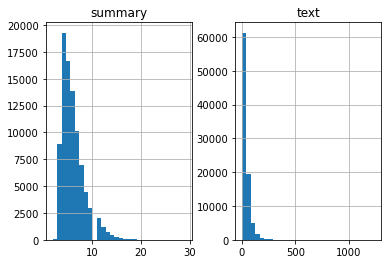

In [24]:
text_word_count=[]
summary_word_count=[]

for i in data['cleaned_text']:
    text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
    summary_word_count.append(len(i.split()))

length_df=pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins=30)
plt.show()

In [43]:
d={}
for i in text_word_count:
    d[i]=0
for i in text_word_count:
    d[i]=d[i]+1
max=0
for i in text_word_count:
    if(d[i]>max):
        max=d[i]
        j=i

In [50]:
print(max, j, d[j])

2780 13 2780


In [53]:
max_len_text=80
max_len_summary=10

(79578,) (79578,) (8843,) (8843,)


## Preparing the Tokenizer

In [66]:
tokenizerx = Tokenizer()
tokenizerx.fit_on_texts(data['cleaned_text'])
data_train = tokenizerx.texts_to_sequences(data['cleaned_text'])

tokenizery = Tokenizer()
tokenizery.fit_on_texts(data['cleaned_summary'])
data_test = tokenizery.texts_to_sequences(data['cleaned_summary'])

In [67]:
# Padding
data_train = pad_sequences(data_train, maxlen=max_len_text, padding='post')
data_test = pad_sequences(data_test, maxlen = max_len_summary, padding = 'post')


In [68]:
X = len(tokenizerx.word_index) + 1
Y = len(tokenizery.word_index) + 1
X, Y

(55139, 14847)

In [61]:
x_train, x_test, y_train, y_test = train_test_split(data_train, data_test, test_size=0.1, random_state=0, shuffle=True)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(79578, 80) (79578, 10) (8843, 80) (8843, 10)


In [ ]:
latent_dim=500

#Encoder
encoder_inputs = Input(shape = (max_len_text))
encoder_emb = Embedding(X, latent_dim, trainable = True)(encoder_inputs)

#LSTM1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_emb)

#LSTM2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output1)

#Set the Decoder
decoder_inputs = Input(shape=(None,))  
decoder_emb = Embedding(Y, latent_dim, trainable=True)(decoder_inputs)

#1st layer of decoder taking last layer of encoder as input
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_emb, initial_state=[stat_h, state_c])

#Attention layer
AttentionLayer attn_layer = AttentionLayer(name = 'attention_layer')
attn_outs, attn_states = attn_layer([encoder_outputs, decoder_outputs])

#Concatenate attention output and decoder LSTM outptut
